# Computer Assignment 5 Phase 1
# Feed Forward Neural Network 
## Ali Bahari

Project Name: Computer Assignment 5 Phase 1 Feed Forward Neural Network

Project Goal: Implement a feed forward neural network for image classification then train the model with the provided images in the train dataset and finally test the model using the provided images in the test dataset. 

In this assignment we're going to implement a feed forward neural network which will be used for image classification. Train and test datasets are provided and in each of them there are many 28 by 28 images which are represented by 784 numbers between 0 to 255 which corresponds to each pixel's brightness. First we start by preprocessing the dataset, taking a look at some of the images to understand how the dataset looks like, and we'll do some modifications to make the dataset ready for being sent to the neural network. For implementing the neural network, required explanation is provided at each step further down the report. Finally after implementation training the model and tuning the hyperparameters are done and the model is tested using the preprocessed test dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
train_dataset = pd.read_csv("./dataset/train_images.csv")
train_labels = pd.read_csv("./dataset/train_labels.csv")

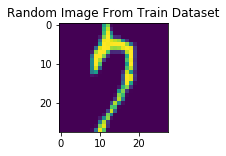

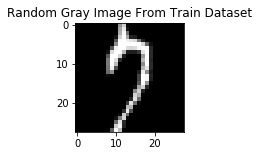

Minimum value in image: 0
Maximum value in image: 255


In [3]:
image = np.array(train_dataset.iloc[random.randint(0 , len(train_dataset) - 1) , 1:]).reshape(28 , 28)

plt.figure(figsize = (2 , 2))
plt.imshow(image)
plt.title("Random Image From Train Dataset")
plt.show()

plt.figure(figsize = (2 , 2))
plt.imshow(image , cmap = "gray")
plt.title("Random Gray Image From Train Dataset")
plt.show()

print("==========================")

print("Minimum value in image: " + str(np.amin(image)))
print("Maximum value in image: " + str(np.amax(image)))

As shown above image values in the dataset which represent the brightness of each pixel is a number between 0 to 255.

=============== CLASS 0 ===============


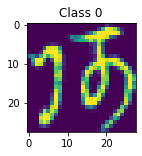

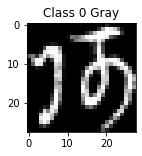

=============== CLASS 1 ===============


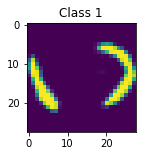

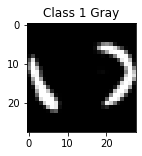

=============== CLASS 2 ===============


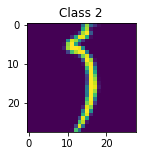

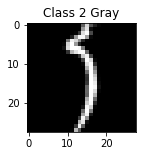

=============== CLASS 3 ===============


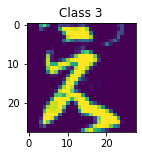

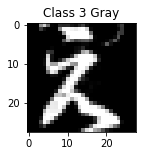

=============== CLASS 4 ===============


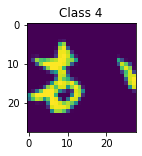

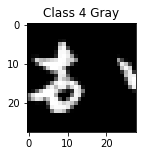

=============== CLASS 5 ===============


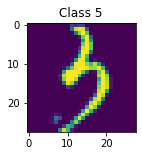

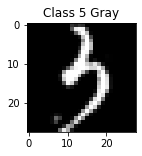

=============== CLASS 6 ===============


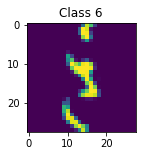

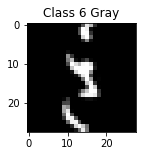

=============== CLASS 7 ===============


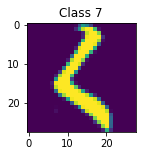

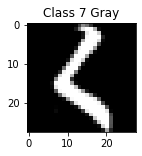

=============== CLASS 8 ===============


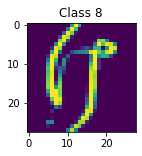

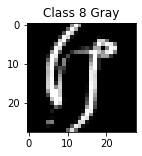

=============== CLASS 9 ===============


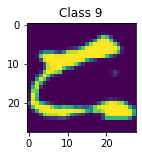

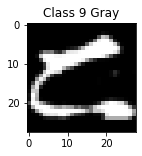

=============== CLASS 10 ===============


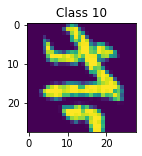

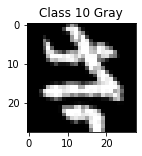

=============== CLASS 11 ===============


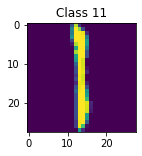

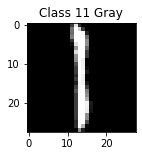

=============== CLASS 12 ===============


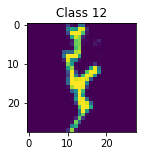

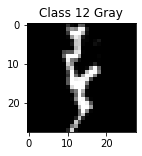

=============== CLASS 13 ===============


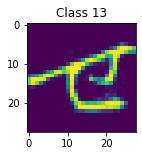

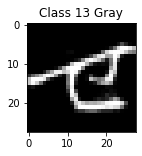

=============== CLASS 14 ===============


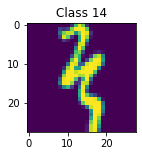

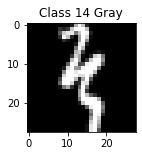

=============== CLASS 15 ===============


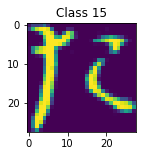

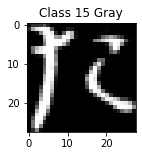

=============== CLASS 16 ===============


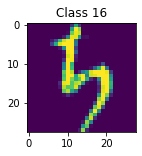

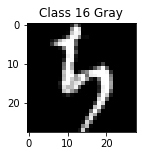

=============== CLASS 17 ===============


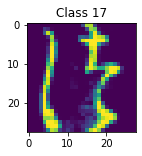

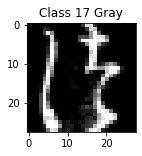

=============== CLASS 18 ===============


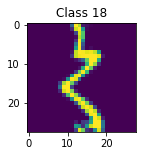

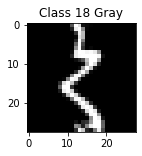

=============== CLASS 19 ===============


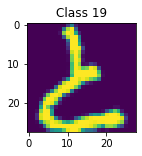

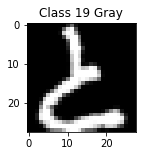

In [4]:
for classNumber in range(20):
    imageRowNum = train_labels[train_labels.iloc[: , 1] == classNumber].iloc[0 , 0]
    image = np.array(train_dataset.iloc[imageRowNum , 1:]).reshape(28 , 28)
    
    print("=============== CLASS " + str(classNumber) + " ===============")
    
    plt.figure(figsize = (2 , 2))
    plt.imshow(image)
    plt.title("Class " + str(classNumber))
    plt.show()
    
    plt.figure(figsize = (2 , 2))
    plt.imshow(image , cmap = "gray")
    plt.title("Class " + str(classNumber) + " Gray")
    plt.show()

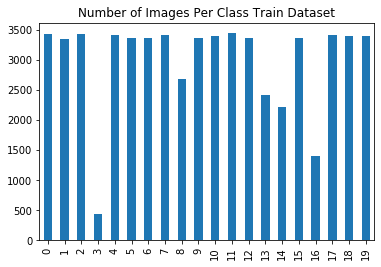

In [5]:
train_labels.iloc[: , 1].value_counts().sort_index().plot(kind = "bar", title = "Number of Images Per Class Train Dataset");

In [3]:
train_dataset_matrix = train_dataset.iloc[: , 1:].to_numpy()
train_labels_matrix = train_labels.iloc[: , 1].to_numpy()

train_dataset_matrix = train_dataset_matrix / 255

Since maximum value in the dataset is 255 it's a good idea to divide every value in the dataset by 255, this will result in each value being between 0 to 1. The reason that this procedure is done is that higher numbers in the network will make it biased meaning that since the difference between values in the range of 0 to 255 is a lot the effect of a value like 1 can easily be vanished comapred to 255 so it's a wise move to scale the values down to make each of them have somewhat of a equal impact in the network. Biased network can result in lower accuracy and all in all a poor model.

# Dataloader

In [4]:
class Dataloader:
    
    def __init__(self, data, labels, n_classes, batch_size=None, shuffle=False):

        assert len(data)==len(labels)
        self.__n_classes = n_classes
        self.__batch_size = batch_size
        self.__shuffle = shuffle
        self.__data = data
        self.__onehot_labels = self.__onehot(labels, self.__n_classes)
    
    def __onehot(self, labels, n_classes):
        matrix = []
        for label in labels:
            row = []
            for numClass in range(n_classes):
                if(numClass == label):
                    row.append(1)
                else:
                    row.append(0)
            
            matrix.append(row)
        
        return np.matrix(matrix , copy = False)
    
    def __shuffle_dataset(self):
        randomIndices = np.random.permutation(len(self.__data))
        self.__data = self.__data[randomIndices]
        self.__onehot_labels = self.__onehot_labels[randomIndices]
    
    def __iter__(self):
        
        if self.__shuffle:
            self.__shuffle_dataset()
            
        if self.__batch_size==None:
            yield (np.matrix(self.__data), np.matrix(self.__onehot_labels))
            return
            
        for idx in range(0, len(self.__data), self.__batch_size):
            yield (np.matrix(self.__data[idx:idx+self.__batch_size]), 
                   np.matrix(self.__onehot_labels[idx:idx+self.__batch_size]))

The codes for one hot and shuffle are pretty straight forward.

# Activation Functions

In [5]:
class Identical:
    
    def __init__(self): pass
    
    def __val(self, matrix):
        identical_value = np.matrix(matrix, dtype=float)
        return identical_value

    def derivative(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        identical_derivative = np.matrix(np.full(np.shape(temp), 1.))
        return identical_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)
    

class Relu:
    
    def __init__(self): pass
    
    def __val(self, matrix):
        return np.maximum(0 , matrix)

    def derivative(self, matrix):
        derivativeReluMatrix = np.matrix(matrix)
        derivativeReluMatrix[matrix < 0] = 0; derivativeReluMatrix[matrix >= 0] = 1
        return derivativeReluMatrix
    
    def __call__(self, matrix):
        return self.__val(matrix)

    
class LeakyRelu:
    
    def __init__(self, negative_slope=0.01):
        self.negative_slope = 0.01
    
    def __val(self, matrix):
        leakyReluMatrix = np.matrix(matrix)
        leakyReluMatrix = np.where(leakyReluMatrix < 0, self.negative_slope * leakyReluMatrix , leakyReluMatrix)
        return leakyReluMatrix

    def derivative(self, matrix):
        derivativeLeakyReluMatrix = np.matrix(matrix)
        derivativeLeakyReluMatrix = np.where(derivativeLeakyReluMatrix < 0 , self.negative_slope , 1)
        return derivativeLeakyReluMatrix
    
    def __call__(self, matrix):
        return self.__val(matrix)

    
class Sigmoid:
    
    def __init__(self): pass

    def __val(self, matrix):
        return np.matrix(1 / (1 + np.exp(-matrix)))

    def derivative(self, matrix):
        return np.multiply(self.__val(matrix) , np.matrix(1 - self.__val(matrix)))
    
    def __call__(self, matrix):
        return self.__val(matrix)


class Softmax:
    
    def __init__(self): pass

    def __val(self, matrix):
        # Stable Softmax hence the subtraction
        # Axis 1 means horizontal
        stableSoftmaxMatrix = np.matrix(matrix)
        stableSoftmaxMatrix = stableSoftmaxMatrix - stableSoftmaxMatrix.max(axis = 1)
        return np.matrix(np.exp(stableSoftmaxMatrix) / np.exp(stableSoftmaxMatrix).sum(axis = 1))
    
    def __call__(self, matrix):
        return self.__val(matrix)
    
class Tanh:
    
    def __init__(self): pass

    def __val(self, matrix):
        return np.matrix((np.exp(matrix) - np.exp(-matrix)) / (np.exp(matrix) + np.exp(-matrix)))

    def derivative(self, matrix):
        return 1 - np.power(self.__val(matrix) , 2)
    
    def __call__(self, matrix):
        return self.__val(matrix)

# Loss Function

In [6]:
class CrossEntropy: #(with softmax)
    
    def __init__(self): pass

    def __val(self, true_val, expected_val):
        assert np.shape(true_val)==np.shape(expected_val)
        
        cross_entropy_value = -np.multiply(expected_val , np.log(Softmax()(true_val) )).sum(axis = 1) 
        return cross_entropy_value
        
    def derivative(self, true_val, expected_val):
        assert np.shape(true_val)==np.shape(expected_val)
        return Softmax()(true_val) - expected_val
    
    def __call__(self, true_val, expected_val):
        return self.__val(true_val, expected_val)

# Layer

In [7]:
class Layer:

    DEFAULT_LOW, DEFAULT_HIGH, DEFAULT_MEAN, DEFAULT_VAR = 0, 0.05, 0., 1.
  
    def __init__(self, input_size, output_size, 
                 activation=Identical(), initial_weight='uniform', **initializing_parameters):
        
        assert type(initial_weight)==str, 'Undefined activation function!'
        
        self.__weight_initializer_dict = {'uniform':self.__uniform_weight, 'normal':self.__normal_weight}
        
        assert initial_weight in self.__weight_initializer_dict, 'Undefined weight initialization function!'


        self.__n_neurons = output_size
        weight_initializer = self.__weight_initializer_dict[initial_weight]
        self.__weight = weight_initializer(input_size, self.__n_neurons, **initializing_parameters)
        self.__bias = weight_initializer(1, self.__n_neurons, **initializing_parameters)
        self.__activation = activation
        
        self.__last_input = None
        self.__last_activation_input = None
        self.__last_activation_output = None
        self.__last_activation_derivative = None
        
    def forward(self, layer_input):
        assert np.ndim(layer_input)==2
        assert np.size(self.__weight,0) == np.size(layer_input,1)
        
        self.__last_input = layer_input
        self.__last_activation_input = np.matmul(layer_input , self.__weight) + self.__bias
        self.__last_activation_output = self.__activation(self.__last_activation_input)
        self.__last_activation_derivative = self.__activation.derivative(self.__last_activation_input)
        
        return self.__last_activation_output
    
    def update_weights(self, backprop_tensor, lr):
        assert np.ndim(backprop_tensor)==2
        assert np.size(backprop_tensor,0) == np.size(self.__last_activation_derivative,0)
        assert np.size(backprop_tensor,1) == self.__n_neurons
        
        weightsTransposed = self.__weight.transpose()
        inputsTransposed = self.__last_input.transpose()
        
        deltaCurrent = np.multiply(backprop_tensor , self.__last_activation_derivative)
        
        weightsDerivative = np.matmul(inputsTransposed , deltaCurrent)
        biasDerivative = np.matmul(np.ones(deltaCurrent.shape[0]) , deltaCurrent)
        
        self.__weight = self.__weight - lr * weightsDerivative
        self.__bias = self.__bias - lr * biasDerivative
        
        backprop_tensor = np.matmul(deltaCurrent , weightsTransposed)
        
        return backprop_tensor

    def __uniform_weight(self, dim1, dim2, **initializing_parameters):
        low, high = self.DEFAULT_LOW, self.DEFAULT_HIGH
        if 'low' in initializing_parameters.keys(): low = initializing_parameters['low']
        if 'high' in initializing_parameters.keys(): high = initializing_parameters['high']
        
        randomUniformWeights = np.random.uniform(low , high , size = (dim1 , dim2))        
        return np.matrix(randomUniformWeights)

    def __normal_weight(self, dim1, dim2, **initializing_parameters):
        mean, var = self.DEFAULT_MEAN, self.DEFAULT_VAR
        if 'mean' in initializing_parameters.keys(): mean = initializing_parameters['mean']
        if 'var' in initializing_parameters.keys(): var = initializing_parameters['var']
        
        randomNormalWeights = np.random.normal(mean , var ** 0.5 , size = (dim1 , dim2))
        return np.matrix(randomNormalWeights)
    
    def getLastActivationOutput(self):
        return self.__last_activation_output
    
    @property
    def n_neurons(self): return self.__n_neurons
    
    @property
    def weight(self): return self.__weight
    
    @property
    def bias(self): return self.__bias
    
    @property
    def activation(self): return self.__activation

#### Importent Note!!!

In layer, all TODO methods were pretty straight forward bu update_weights method was challenging and really hard to visualize and code so to make the steps taken above to code update_weights more clear there's a provided picture in delivered files named "update_weights Thought Process.jpg" which shows the calculations that I've done on paper and the also the steps that I've taken. It's kinda messy but I thought It's worth it to show the thought process that went behind coding update_weights.

# Feed Forward Neural Network

In [8]:
class FeedForwardNN:
    
    def __init__(self, input_shape):
        
        self.__input_shape = input_shape
        self.__output_shape = None
        
        self.__layers_list = []
        
        self.__lr = None
        self.__loss = None

        
    def add_layer(self, n_neurons, activation=Relu(), initial_weight='uniform', **initializing_parameters):
         
        assert type(n_neurons)==int, "Invalid number of neurons for the layer!"
        assert n_neurons>0, "Invalid number of neurons for the layer!"
        
        n_prev_neurons = self.__input_shape if len(self.__layers_list)==0 else self.__layers_list[-1].n_neurons
        new_layer = Layer(n_prev_neurons, n_neurons, activation, initial_weight, **initializing_parameters)
        self.__layers_list.append(new_layer)
        self.__output_shape = self.__layers_list[-1].n_neurons 
      
    
    def set_training_param(self, loss=CrossEntropy(), lr=1e-3):
        assert self.__layers_list, "Uncomplete model!"
        self.__loss = loss
        self.__lr = lr
    
    
    def forward(self, network_input):
        assert type(self.__output_shape) != None, "Model is not compiled!"
        
        network_output = network_input
        for layer in self.__layers_list:
            network_output = layer.forward(network_output)
        
        return network_output
    
    
    def fit(self, epochs, trainloader, testloader=None, print_results=True):
        
        assert type(self.__output_shape) != None, "Model is not compiled!"
        assert type(self.__lr) != None and type(self.__loss) != None, "Training paramenters are not set!"

        log = {"train_accuracy":[], "train_loss":[], "test_accuracy":[], "test_loss":[]}
        
        for epoch in range(1, epochs+1):
            
            if print_results: 
                print('Epoch {}:'.format(epoch)) 
                
            average_accuracy, average_loss = self.__train(trainloader)
            log['train_accuracy'].append(average_accuracy)
            log['train_loss'].append(average_loss)
            if print_results:
                print('\tTrain: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
            
            if type(testloader) != type(None):
                average_accuracy, average_loss = self.__test(testloader)
                log['test_accuracy'].append(average_accuracy)
                log['test_loss'].append(average_loss)
                if print_results:
                    print('\tTest: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
                    
        return log
    
    
    def __train(self, trainloader):
        bach_accuracies, batch_losses = [], []
        for x_train, y_train in trainloader:
            batch_accuracy, batch_loss = self.__train_on_batch(x_train, y_train)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)
    
    
    def __test(self, testloader):
        bach_accuracies, batch_losses = [], []
        for x_test, y_test in testloader:
            batch_accuracy, batch_loss = self.__test_on_batch(x_test, y_test)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)

    
    def __train_on_batch(self, x_batch, y_batch):
        forwardResult = self.forward(x_batch)
        batch_accuracy = self.__compute_accuracy(forwardResult , y_batch)
        batch_average_loss = self.__update_weights(forwardResult , y_batch)
        
        return (batch_accuracy, batch_average_loss)
        
        
    def __test_on_batch(self, x_batch, y_batch):
        forwardResult = self.forward(x_batch)
        batch_accuracy = self.__compute_accuracy(forwardResult , y_batch)
        batch_average_loss = np.sum(CrossEntropy()(forwardResult , y_batch)) / len(forwardResult)
        
        return (batch_accuracy, batch_average_loss)
            
        
    def __get_labels(self, outputs):
        return outputs.argmax(axis = 1)
    
    
    def __compute_accuracy(self, output, expected_output):
        corrects = np.sum(np.argmax(output , axis = 1) == np.argmax(expected_output , axis = 1))
        return (corrects / len(np.argmax(output , axis = 1))) * 100
    
    
    def __update_weights(self, output, y_train):
        crossEntropy = CrossEntropy()
        derivativeCE = crossEntropy.derivative(output , y_train)
        for layer in self.__layers_list[::-1]:
            derivativeCE = layer.update_weights(derivativeCE , self.__lr)
        
        return np.sum(crossEntropy(output , y_train)) / len(output)

Since here we're doing the network processes some methods are done in a recursive like manner but no worries they're pretty straight forward as well.

# Training Sample Code

In [9]:
test_dataset = pd.read_csv("./dataset/test_images.csv")
test_labels = pd.read_csv("./dataset/test_labels.csv")

In [10]:
test_dataset_matrix = test_dataset.iloc[: , 1:].to_numpy()
test_labels_matrix = test_labels.iloc[: , 1].to_numpy()

test_dataset_matrix = test_dataset_matrix / 255

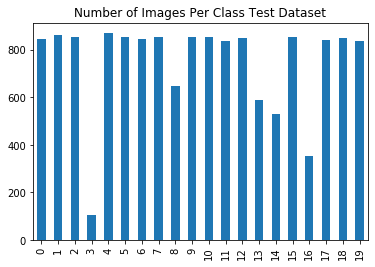

In [14]:
test_labels.iloc[: , 1].value_counts().sort_index().plot(kind = "bar" , title = "Number of Images Per Class Test Dataset");

After loading test set and doing the same preprocesses as before we're ready to test our model.

#### Network Architecture

The neural network that I implemented consists of 1 input layer, 1 hidden layer and 1 output layer. 784 input nodes, 30 hidden nodes and 20 output nodes corresponding to 20 labels that we have.

I have tried higher number of hidden nodes and it'll result in higher accuracy I even reached 83 percent accuracy on test set with 100 nodes in hidden layer but at the end for getting the results faster I set 30 nodes for hidden layer but I can't say this enough feel absolutely free to raise the number of hidden nodes to get higher accuracy.

In [11]:
def generateTrainLoader(train_dataset_matrix , train_labels_matrix , numClasses , batchSize):
    TRAINLOADER = []
    trainLoader = Dataloader(train_dataset_matrix , train_labels_matrix , numClasses , batchSize , True)
    for data in trainLoader:
        TRAINLOADER.append(data)
        
    return TRAINLOADER


def generateTestLoader(test_dataset_matrix , test_labels_matrix , numClasses , batchSize):
    TESTLOADER = []
    testLoader = Dataloader(test_dataset_matrix , test_labels_matrix , numClasses , batchSize , True)
    for data in testLoader:
        TESTLOADER.append(data)
        
    return TESTLOADER

If zero initial weights are chosen, then the learning rate has no influence on a neuron's predicted class label. If you initialize all weights with zeros then every hidden unit will get zero independent of the input since the weight matrix is all zeros and multiplication will result in zero. So, when all the hidden neurons start with the zero weights, then all of them will follow the same gradient and for this reason starting with zeros affects only the scale of the weight vector, not the direction. Also, having zero weights to start with will prevent the network from learning. The errors backpropagated through the network is proportional to the value of the weights. If all the weights are the same, then the backpropagated errors will be the same, so all of the weights will be updated by the same amount which means the whole process was useless. To avoid this problem, the initial weights of the network should be unequal a way of doing this is to assign random values to weights.

## Learning Rate

In [24]:
INPUT_SHAPE = 28 * 28
LEARNING_RATE = 0.001
EPOCHS = 20
NUM_CLASSES = 20
BATCH_SIZE = 64
TRAINLOADER = generateTrainLoader(train_dataset_matrix , train_labels_matrix , NUM_CLASSES , BATCH_SIZE)
TESTLOADER = generateTestLoader(test_dataset_matrix , test_labels_matrix , NUM_CLASSES , BATCH_SIZE)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30 , input_shape = INPUT_SHAPE, activation = Relu(), weight_initializer = "uniform")
network.add_layer(NUM_CLASSES , activation = Identical(), weight_initializer = "uniform")
network.set_training_param(loss = CrossEntropy() , lr = LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 58.178971215351815	Average Loss: 1.4768819539056393
	Test: Average Accuracy: 62.00354609929077	Average Loss: 1.355892506710028
Epoch 2:
	Train: Average Accuracy: 76.26765724946695	Average Loss: 0.8655954191931076
	Test: Average Accuracy: 66.1613475177305	Average Loss: 1.2165055813230448
Epoch 3:
	Train: Average Accuracy: 79.13612739872069	Average Loss: 0.7641494343937469
	Test: Average Accuracy: 68.56382978723404	Average Loss: 1.1391483501724085
Epoch 4:
	Train: Average Accuracy: 81.00179904051173	Average Loss: 0.6962329406848429
	Test: Average Accuracy: 70.37234042553192	Average Loss: 1.077130731573483
Epoch 5:
	Train: Average Accuracy: 82.49433635394456	Average Loss: 0.6417369698097634
	Test: Average Accuracy: 71.72872340425532	Average Loss: 1.026201491871417
Epoch 6:
	Train: Average Accuracy: 83.55377132196162	Average Loss: 0.5972652211164089
	Test: Average Accuracy: 72.9366134751773	Average Loss: 0.987033495170152
Epoch 7:
	Train: Average Accuracy

In [19]:
INPUT_SHAPE = 28 * 28
LEARNING_RATE = 0.01
EPOCHS = 20
NUM_CLASSES = 20
BATCH_SIZE = 64
TRAINLOADER = generateTrainLoader(train_dataset_matrix , train_labels_matrix , NUM_CLASSES , BATCH_SIZE)
TESTLOADER = generateTestLoader(test_dataset_matrix , test_labels_matrix , NUM_CLASSES , BATCH_SIZE)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30 , input_shape = INPUT_SHAPE, activation = Relu(), weight_initializer = "uniform")
network.add_layer(NUM_CLASSES , activation = Identical(), weight_initializer = "uniform")
network.set_training_param(loss = CrossEntropy() , lr = LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 5.600346481876333	Average Loss: 2.9715821778381564
	Test: Average Accuracy: 5.6227836879432616	Average Loss: 2.949812932419543
Epoch 2:
	Train: Average Accuracy: 5.588686034115138	Average Loss: 2.951386123930466
	Test: Average Accuracy: 5.6227836879432616	Average Loss: 2.94981443264841
Epoch 3:
	Train: Average Accuracy: 5.5903518123667375	Average Loss: 2.95138135662561
	Test: Average Accuracy: 5.6227836879432616	Average Loss: 2.949814287361184
Epoch 4:
	Train: Average Accuracy: 5.5903518123667375	Average Loss: 2.951377877972966
	Test: Average Accuracy: 5.6227836879432616	Average Loss: 2.9498130544858725
Epoch 5:
	Train: Average Accuracy: 5.5903518123667375	Average Loss: 2.951374735388756
	Test: Average Accuracy: 5.6227836879432616	Average Loss: 2.9498124261786534
Epoch 6:
	Train: Average Accuracy: 5.5903518123667375	Average Loss: 2.9513718181198585
	Test: Average Accuracy: 5.6227836879432616	Average Loss: 2.9498104432669936
Epoch 7:
	Train: Average Ac

In [20]:
INPUT_SHAPE = 28 * 28
LEARNING_RATE = 0.1
EPOCHS = 20
NUM_CLASSES = 20
BATCH_SIZE = 64
TRAINLOADER = generateTrainLoader(train_dataset_matrix , train_labels_matrix , NUM_CLASSES , BATCH_SIZE)
TESTLOADER = generateTestLoader(test_dataset_matrix , test_labels_matrix , NUM_CLASSES , BATCH_SIZE)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30 , input_shape = INPUT_SHAPE, activation = Relu(), weight_initializer = "uniform")
network.add_layer(NUM_CLASSES , activation = Identical(), weight_initializer = "uniform")
network.set_training_param(loss = CrossEntropy() , lr = LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 5.640325159914712	Average Loss: 3.1321971011329395
	Test: Average Accuracy: 5.69813829787234	Average Loss: 2.967495592937405
Epoch 2:
	Train: Average Accuracy: 5.658648720682303	Average Loss: 2.977034845950102
	Test: Average Accuracy: 5.69813829787234	Average Loss: 2.967495592937405
Epoch 3:
	Train: Average Accuracy: 5.658648720682303	Average Loss: 2.977034845950102
	Test: Average Accuracy: 5.69813829787234	Average Loss: 2.967495592937405
Epoch 4:
	Train: Average Accuracy: 5.658648720682303	Average Loss: 2.977034845950102
	Test: Average Accuracy: 5.69813829787234	Average Loss: 2.967495592937405
Epoch 5:
	Train: Average Accuracy: 5.658648720682303	Average Loss: 2.977034845950102
	Test: Average Accuracy: 5.69813829787234	Average Loss: 2.967495592937405
Epoch 6:
	Train: Average Accuracy: 5.658648720682303	Average Loss: 2.977034845950102
	Test: Average Accuracy: 5.69813829787234	Average Loss: 2.967495592937405
Epoch 7:
	Train: Average Accuracy: 5.65864872

In [21]:
INPUT_SHAPE = 28 * 28
LEARNING_RATE = 0.0001
EPOCHS = 20
NUM_CLASSES = 20
BATCH_SIZE = 64
TRAINLOADER = generateTrainLoader(train_dataset_matrix , train_labels_matrix , NUM_CLASSES , BATCH_SIZE)
TESTLOADER = generateTestLoader(test_dataset_matrix , test_labels_matrix , NUM_CLASSES , BATCH_SIZE)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30 , input_shape = INPUT_SHAPE, activation = Relu(), weight_initializer = "uniform")
network.add_layer(NUM_CLASSES , activation = Identical(), weight_initializer = "uniform")
network.set_training_param(loss = CrossEntropy() , lr = LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 11.322294776119403	Average Loss: 2.854677081887793
	Test: Average Accuracy: 22.728280141843975	Average Loss: 2.668491597206269
Epoch 2:
	Train: Average Accuracy: 40.17357409381663	Average Loss: 2.247960472828343
	Test: Average Accuracy: 43.24911347517731	Average Loss: 2.1079261565042477
Epoch 3:
	Train: Average Accuracy: 57.845815565031984	Average Loss: 1.630623989779955
	Test: Average Accuracy: 49.827127659574465	Average Loss: 1.7539346302019594
Epoch 4:
	Train: Average Accuracy: 64.0591684434968	Average Loss: 1.3149555662678394
	Test: Average Accuracy: 54.410460992907794	Average Loss: 1.5873370072930424
Epoch 5:
	Train: Average Accuracy: 67.60227878464819	Average Loss: 1.1691384476062705
	Test: Average Accuracy: 57.30274822695035	Average Loss: 1.4932626936188598
Epoch 6:
	Train: Average Accuracy: 69.76779051172709	Average Loss: 1.08694424997412
	Test: Average Accuracy: 59.151152482269495	Average Loss: 1.4317471294986357
Epoch 7:
	Train: Average Accu

In [23]:
INPUT_SHAPE = 28 * 28
LEARNING_RATE = 0.0035
EPOCHS = 20
NUM_CLASSES = 20
BATCH_SIZE = 64
TRAINLOADER = generateTrainLoader(train_dataset_matrix , train_labels_matrix , NUM_CLASSES , BATCH_SIZE)
TESTLOADER = generateTestLoader(test_dataset_matrix , test_labels_matrix , NUM_CLASSES , BATCH_SIZE)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30 , input_shape = INPUT_SHAPE, activation = Relu(), weight_initializer = "uniform")
network.add_layer(NUM_CLASSES , activation = Identical(), weight_initializer = "uniform")
network.set_training_param(loss = CrossEntropy() , lr = LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 57.75086620469083	Average Loss: 1.4537424266291636
	Test: Average Accuracy: 68.75886524822695	Average Loss: 1.1403461432090212
Epoch 2:
	Train: Average Accuracy: 80.21055437100213	Average Loss: 0.7094497321305481
	Test: Average Accuracy: 72.07003546099291	Average Loss: 1.013290320836214
Epoch 3:
	Train: Average Accuracy: 82.48600746268657	Average Loss: 0.6241300418722757
	Test: Average Accuracy: 73.84530141843973	Average Loss: 0.9590306384112178
Epoch 4:
	Train: Average Accuracy: 83.80530383795309	Average Loss: 0.5732070900952384
	Test: Average Accuracy: 74.7628546099291	Average Loss: 0.9303130656495107
Epoch 5:
	Train: Average Accuracy: 84.88472814498934	Average Loss: 0.5329478114237235
	Test: Average Accuracy: 75.46542553191489	Average Loss: 0.9190286479970171
Epoch 6:
	Train: Average Accuracy: 85.72927771855011	Average Loss: 0.5022700592143791
	Test: Average Accuracy: 76.18351063829788	Average Loss: 0.9032384609073142
Epoch 7:
	Train: Average Accur

By checking multiple values for learning rate, optimal learning rate was around 0.003 and 0.004 so I chose 0.0035.

The learning rate controls how quickly the model is adapted to the problem. Smaller learning rates require more training epochs given the smaller changes made to the weights each update, whereas larger learning rates result in rapid changes and require fewer training epochs.

If the learning rate is low, then training is more reliable, but optimization will take a lot of time because steps towards the minimum of the loss function are tiny. If the learning rate is high, then training may not converge or even diverge. Weight changes can be so big that the optimizer overshoots the minimum and makes the loss worse.

By taking a look at the results above as we move from 0.001 learning rate towards 0.1 we can see that the accuracy drops noticeably also when lowering learning rate to 0.0001 we can see that the accuracy with 20 epochs isn't good. The results approves the explanations above. Too high there might be overshoot therefore lower rates and higher loss, Too low the network won't converge even if it does it'll take too much time so it won't be efficient.

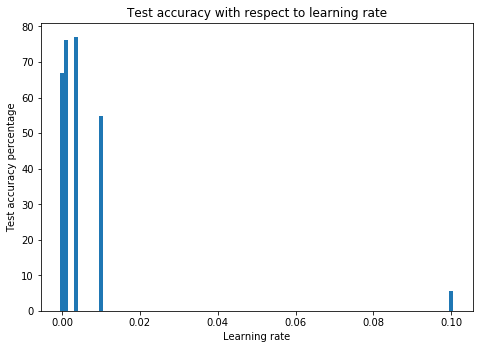

In [25]:
learningRates = [0.001 , 0.01 , 0.1 , 0.0001 , 0.0035]
testAccuracy = [76.06604609929079 , 54.736258865248224 , 5.69813829787234 , 66.99024822695036 , 77.15868794326241]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.title("Test accuracy with respect to learning rate")
plt.xlabel("Learning rate")
plt.ylabel("Test accuracy percentage")
ax.bar(learningRates , testAccuracy , width = 0.001)
plt.show()

## Activation Function

In [131]:
INPUT_SHAPE = 28 * 28
LEARNING_RATE = 0.0035
EPOCHS = 20
NUM_CLASSES = 20
BATCH_SIZE = 64
TRAINLOADER = generateTrainLoader(train_dataset_matrix , train_labels_matrix , NUM_CLASSES , BATCH_SIZE)
TESTLOADER = generateTestLoader(test_dataset_matrix , test_labels_matrix , NUM_CLASSES , BATCH_SIZE)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30 , input_shape = INPUT_SHAPE, activation = Sigmoid(), weight_initializer = "uniform")
network.add_layer(NUM_CLASSES , activation = Identical(), weight_initializer = "uniform")
network.set_training_param(loss = CrossEntropy() , lr = LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 25.951159381663114	Average Loss: 2.4424121575961077
	Test: Average Accuracy: 45.704787234042556	Average Loss: 1.852445325840845
Epoch 2:
	Train: Average Accuracy: 67.86547174840085	Average Loss: 1.206865315780307
	Test: Average Accuracy: 60.944148936170215	Average Loss: 1.3583545221271132
Epoch 3:
	Train: Average Accuracy: 75.13825959488273	Average Loss: 0.9072533783690273
	Test: Average Accuracy: 65.62943262411348	Average Loss: 1.2102771285508531
Epoch 4:
	Train: Average Accuracy: 78.09001865671642	Average Loss: 0.7956122970271343
	Test: Average Accuracy: 67.80363475177305	Average Loss: 1.1267167151813466
Epoch 5:
	Train: Average Accuracy: 79.7008262260128	Average Loss: 0.7308118246617651
	Test: Average Accuracy: 69.3572695035461	Average Loss: 1.0728159277027967
Epoch 6:
	Train: Average Accuracy: 80.95015991471216	Average Loss: 0.6869021958930397
	Test: Average Accuracy: 70.43439716312058	Average Loss: 1.036671096341574
Epoch 7:
	Train: Average Accur

In [132]:
INPUT_SHAPE = 28 * 28
LEARNING_RATE = 0.0035
EPOCHS = 20
NUM_CLASSES = 20
BATCH_SIZE = 64
TRAINLOADER = generateTrainLoader(train_dataset_matrix , train_labels_matrix , NUM_CLASSES , BATCH_SIZE)
TESTLOADER = generateTestLoader(test_dataset_matrix , test_labels_matrix , NUM_CLASSES , BATCH_SIZE)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30 , input_shape = INPUT_SHAPE, activation = Tanh(), weight_initializer = "uniform")
network.add_layer(NUM_CLASSES , activation = Identical(), weight_initializer = "uniform")
network.set_training_param(loss = CrossEntropy() , lr = LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 46.07542643923241	Average Loss: 1.804092978603489
	Test: Average Accuracy: 59.421542553191486	Average Loss: 1.437972982433124
Epoch 2:
	Train: Average Accuracy: 73.57409381663113	Average Loss: 0.9301550336510509
	Test: Average Accuracy: 64.0979609929078	Average Loss: 1.2648256097758959
Epoch 3:
	Train: Average Accuracy: 76.87066897654584	Average Loss: 0.8167961433354676
	Test: Average Accuracy: 65.59840425531915	Average Loss: 1.2230477264012427
Epoch 4:
	Train: Average Accuracy: 78.65305170575692	Average Loss: 0.751531246269135
	Test: Average Accuracy: 67.3936170212766	Average Loss: 1.1713270838613652
Epoch 5:
	Train: Average Accuracy: 79.95569029850746	Average Loss: 0.7052343388965899
	Test: Average Accuracy: 67.92331560283688	Average Loss: 1.1515581180778955
Epoch 6:
	Train: Average Accuracy: 80.89685501066099	Average Loss: 0.6746664283498262
	Test: Average Accuracy: 68.94503546099291	Average Loss: 1.132388411588174
Epoch 7:
	Train: Average Accuracy

In [133]:
INPUT_SHAPE = 28 * 28
LEARNING_RATE = 0.0035
EPOCHS = 20
NUM_CLASSES = 20
BATCH_SIZE = 64
TRAINLOADER = generateTrainLoader(train_dataset_matrix , train_labels_matrix , NUM_CLASSES , BATCH_SIZE)
TESTLOADER = generateTestLoader(test_dataset_matrix , test_labels_matrix , NUM_CLASSES , BATCH_SIZE)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30 , input_shape = INPUT_SHAPE, activation = LeakyRelu(), weight_initializer = "uniform")
network.add_layer(NUM_CLASSES , activation = Identical(), weight_initializer = "uniform")
network.set_training_param(loss = CrossEntropy() , lr = LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 69.64785447761194	Average Loss: 1.1011777915366618
	Test: Average Accuracy: 70.7557624113475	Average Loss: 1.0370865826973885
Epoch 2:
	Train: Average Accuracy: 82.97741204690831	Average Loss: 0.6041814746926142
	Test: Average Accuracy: 73.98271276595744	Average Loss: 0.9204186632594056
Epoch 3:
	Train: Average Accuracy: 85.20622334754798	Average Loss: 0.5229843514001792
	Test: Average Accuracy: 75.41445035460994	Average Loss: 0.8833941321415867
Epoch 4:
	Train: Average Accuracy: 86.41058102345416	Average Loss: 0.48330144260897967
	Test: Average Accuracy: 75.78014184397165	Average Loss: 0.8750199240976185
Epoch 5:
	Train: Average Accuracy: 87.1235341151386	Average Loss: 0.4570902332346356
	Test: Average Accuracy: 76.36968085106383	Average Loss: 0.860946913512459
Epoch 6:
	Train: Average Accuracy: 87.54331023454158	Average Loss: 0.4385004721781792
	Test: Average Accuracy: 76.60017730496453	Average Loss: 0.8633332353587598
Epoch 7:
	Train: Average Accur

LeakyRelu and Relu results are really close to each other but LeakyRelu result value is a bit higher so at the end I chose LeakyRelu.

In Tanh and Sigmoid moving towards the ends of the function, y values react very little to the changes in x so the derivative values in these regions are very small and converge to 0. This is called the vanishing gradient and the learning is minimal meaning that it makes the learning process be very slow or even useless. We know that if 0, not any learning. When slow learning occurs, the optimization algorithm that minimizes error can be attached to local minimum values and cannot get maximum performance from the artificial neural network model.

So by the explanation above Tanh and Sigmoid will result in vanishing gradient meaning that after a while the learning process will be very slow. So since we are using Stochastic Gradient Descent, these activation functions, Sigmoid and Tanh, won't be the best choice.

Unlike Relu, LeakyRelu is more balanced and may therefore learn faster. Also LeakyRelu fixes the dying Relu problem, as it doesn’t have zero-slope parts.

Dying relu problem: A Relu neuron is dead if it’s stuck in the negative side and always outputs 0. Because the slope of Relu in the negative range is also 0, once a neuron gets negative, it’s unlikely for it to recover. Such neurons are not playing any role in discriminating the input and is essentially useless. Over the time you may end up with a large part of your network doing nothing.

Since LeakyRelu assigns a small non zero value for negative parts this will result in solving the problem mentioned above and this is the main advantage of LeakyRelu.

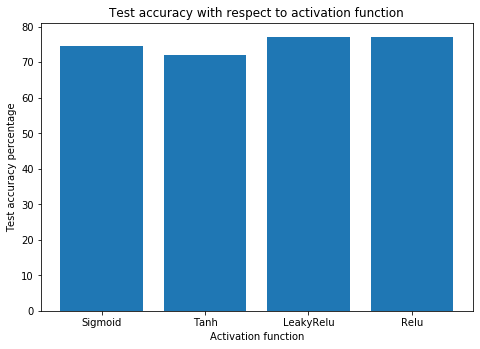

In [26]:
activationFuncs = ["Sigmoid" , "Tanh" , "LeakyRelu" , "Relu"]
testAccuracy = [74.66755319148936 , 71.94813829787235 , 77.19858156028367 , 77.15868794326241]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.title("Test accuracy with respect to activation function")
plt.xlabel("Activation function")
plt.ylabel("Test accuracy percentage")
ax.bar(activationFuncs , testAccuracy)
plt.show()

## Batch Size

In [27]:
INPUT_SHAPE = 28 * 28
LEARNING_RATE = 0.0035
EPOCHS = 20
NUM_CLASSES = 20
BATCH_SIZE = 16
TRAINLOADER = generateTrainLoader(train_dataset_matrix , train_labels_matrix , NUM_CLASSES , BATCH_SIZE)
TESTLOADER = generateTestLoader(test_dataset_matrix , test_labels_matrix , NUM_CLASSES , BATCH_SIZE)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30 , input_shape = INPUT_SHAPE, activation = LeakyRelu(), weight_initializer = "uniform")
network.add_layer(NUM_CLASSES , activation = Identical(), weight_initializer = "uniform")
network.set_training_param(loss = CrossEntropy() , lr = LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 71.315	Average Loss: 1.0170673777616757
	Test: Average Accuracy: 71.47521321961621	Average Loss: 1.0265599160048817
Epoch 2:
	Train: Average Accuracy: 82.68	Average Loss: 0.6157877898995765
	Test: Average Accuracy: 74.57356076759062	Average Loss: 0.9066326772848244
Epoch 3:
	Train: Average Accuracy: 84.77833333333334	Average Loss: 0.535350257210532
	Test: Average Accuracy: 76.04610874200426	Average Loss: 0.8705808461969916
Epoch 4:
	Train: Average Accuracy: 85.945	Average Loss: 0.49282152180746797
	Test: Average Accuracy: 76.83901918976545	Average Loss: 0.847341205391866
Epoch 5:
	Train: Average Accuracy: 86.82166666666667	Average Loss: 0.46375349600575344
	Test: Average Accuracy: 77.56529850746269	Average Loss: 0.8378334597439574
Epoch 6:
	Train: Average Accuracy: 87.45833333333333	Average Loss: 0.4433425530926159
	Test: Average Accuracy: 77.65858208955224	Average Loss: 0.8409592034312217
Epoch 7:
	Train: Average Accuracy: 87.84833333333333	Average L

In [28]:
INPUT_SHAPE = 28 * 28
LEARNING_RATE = 0.0035
EPOCHS = 20
NUM_CLASSES = 20
BATCH_SIZE = 32
TRAINLOADER = generateTrainLoader(train_dataset_matrix , train_labels_matrix , NUM_CLASSES , BATCH_SIZE)
TESTLOADER = generateTestLoader(test_dataset_matrix , test_labels_matrix , NUM_CLASSES , BATCH_SIZE)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30 , input_shape = INPUT_SHAPE, activation = LeakyRelu(), weight_initializer = "uniform")
network.add_layer(NUM_CLASSES , activation = Identical(), weight_initializer = "uniform")
network.set_training_param(loss = CrossEntropy() , lr = LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 72.05	Average Loss: 1.0144157807147478
	Test: Average Accuracy: 71.37304548685147	Average Loss: 1.032771948979803
Epoch 2:
	Train: Average Accuracy: 83.545	Average Loss: 0.5989382693438603
	Test: Average Accuracy: 74.56467661691543	Average Loss: 0.9244933375395132
Epoch 3:
	Train: Average Accuracy: 85.61333333333333	Average Loss: 0.5178895106496411
	Test: Average Accuracy: 76.11718194740584	Average Loss: 0.8860678340956888
Epoch 4:
	Train: Average Accuracy: 86.53166666666667	Average Loss: 0.4805079899280793
	Test: Average Accuracy: 76.5702736318408	Average Loss: 0.8809983089934426
Epoch 5:
	Train: Average Accuracy: 87.185	Average Loss: 0.45621308765314694
	Test: Average Accuracy: 77.05890191897655	Average Loss: 0.873916232583509
Epoch 6:
	Train: Average Accuracy: 87.68166666666667	Average Loss: 0.4379468334048757
	Test: Average Accuracy: 77.20549040511727	Average Loss: 0.8732692631854008
Epoch 7:
	Train: Average Accuracy: 88.01333333333334	Average Los

In [29]:
INPUT_SHAPE = 28 * 28
LEARNING_RATE = 0.0035
EPOCHS = 20
NUM_CLASSES = 20
BATCH_SIZE = 256
TRAINLOADER = generateTrainLoader(train_dataset_matrix , train_labels_matrix , NUM_CLASSES , BATCH_SIZE)
TESTLOADER = generateTestLoader(test_dataset_matrix , test_labels_matrix , NUM_CLASSES , BATCH_SIZE)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30 , input_shape = INPUT_SHAPE, activation = LeakyRelu(), weight_initializer = "uniform")
network.add_layer(NUM_CLASSES , activation = Identical(), weight_initializer = "uniform")
network.set_training_param(loss = CrossEntropy() , lr = LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 22.508865248226954	Average Loss: 2.5079498343916966
	Test: Average Accuracy: 33.86241358162355	Average Loss: 2.155456777804237
Epoch 2:
	Train: Average Accuracy: 46.68384308510638	Average Loss: 1.7405059029183636
	Test: Average Accuracy: 51.3663163470116	Average Loss: 1.7041400570516323
Epoch 3:
	Train: Average Accuracy: 63.330562943262414	Average Loss: 1.260711574038731
	Test: Average Accuracy: 57.675206289027656	Average Loss: 1.4954006240037063
Epoch 4:
	Train: Average Accuracy: 67.16035017730496	Average Loss: 1.1260797750293816
	Test: Average Accuracy: 59.14118253791258	Average Loss: 1.4448595784285323
Epoch 5:
	Train: Average Accuracy: 69.8692375886525	Average Loss: 1.0359759750081263
	Test: Average Accuracy: 60.59112957181088	Average Loss: 1.3859897783556985
Epoch 6:
	Train: Average Accuracy: 72.12544326241134	Average Loss: 0.9631476379703944
	Test: Average Accuracy: 62.35713090990187	Average Loss: 1.3330669866631204
Epoch 7:
	Train: Average Accu

By testing multiple batch sizes I finally chose 32 which had the best results.

The batch size defines the number of samples that will be propagated through the network.

Advantages of using a batch size instead of number of all samples are for instance choosing a batch size requires less memory. Since you train the network using fewer samples, the overall training procedure requires less memory. That's especially important if you are not able to fit the whole dataset in your machine's memory. Typically networks train faster with batches. That's because we update the weights after each propagation. If we used all samples during propagation we would make only one update for the network's parameter meaning that the update won't occur frequently.

So the main advantage of dividing the whole dataset into batches and train the network with these batches is that parameter updates will happen frequently so the training process will be better also having batches will require less computation power and memory. Also by using batches and incorporating parallel computing the learning process can be much faster but if we use the whole dataset we can't use parallel computing to our advantage.

The smaller the batch the less accurate the estimate of the gradient will be. This means that parameter updates won't be reliable and aren't the best possible updates so the learning process won't be great. On the other hand, smaller batches can lead to better regularization and they'll make the learning process faster and also less memory is needed at each run. Small batch training has been shown to provide improved generalization performance.

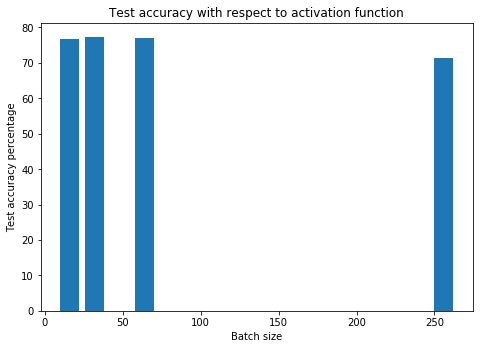

In [31]:
batchSizes = [16 , 32 , 64 , 256]
testAccuracy = [76.83901918976545 , 77.43425728500355 , 77.09858156028367 , 71.47775423728814]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.title("Test accuracy with respect to activation function")
plt.xlabel("Batch size")
plt.ylabel("Test accuracy percentage")
ax.bar(batchSizes , testAccuracy , width = 12)
plt.show()

## Epoch

Gradient Descent is an iterative process so, updating the weights with single pass or one epoch is not enough. One epoch leads to underfitting. As the number of epochs increases, more times the weights are changed in the neural network so the curve goes from underfitting to optimal to overfitting curve. So in total since updating the weights needs multiple number of passings (epochs) we'll have to train the model for multiple epochs.

In [12]:
INPUT_SHAPE = 28 * 28
LEARNING_RATE = 0.0035
EPOCHS = 100
NUM_CLASSES = 20
BATCH_SIZE = 32
TRAINLOADER = generateTrainLoader(train_dataset_matrix , train_labels_matrix , NUM_CLASSES , BATCH_SIZE)
TESTLOADER = generateTestLoader(test_dataset_matrix , test_labels_matrix , NUM_CLASSES , BATCH_SIZE)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30 , input_shape = INPUT_SHAPE, activation = LeakyRelu(), weight_initializer = "uniform")
network.add_layer(NUM_CLASSES , activation = Identical(), weight_initializer = "uniform")
network.set_training_param(loss = CrossEntropy() , lr = LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 72.29166666666667	Average Loss: 1.0024906697810128
	Test: Average Accuracy: 71.80392679459842	Average Loss: 1.0172703750356926
Epoch 2:
	Train: Average Accuracy: 83.335	Average Loss: 0.5919844805525035
	Test: Average Accuracy: 74.2093105899076	Average Loss: 0.9323417935520005
Epoch 3:
	Train: Average Accuracy: 85.265	Average Loss: 0.517436407425936
	Test: Average Accuracy: 75.5863539445629	Average Loss: 0.9019398984028036
Epoch 4:
	Train: Average Accuracy: 86.345	Average Loss: 0.476243410270417
	Test: Average Accuracy: 76.37926439232409	Average Loss: 0.8853316224661576
Epoch 5:
	Train: Average Accuracy: 87.12166666666667	Average Loss: 0.45074294414455784
	Test: Average Accuracy: 76.82125088841507	Average Loss: 0.8796248004761615
Epoch 6:
	Train: Average Accuracy: 87.65666666666667	Average Loss: 0.43331366598146465
	Test: Average Accuracy: 76.9633972992182	Average Loss: 0.8749659217227944
Epoch 7:
	Train: Average Accuracy: 87.95833333333333	Average Los

	Train: Average Accuracy: 91.98833333333333	Average Loss: 0.2810935457150357
	Test: Average Accuracy: 75.33093461265103	Average Loss: 1.2311269152200328
Epoch 54:
	Train: Average Accuracy: 91.955	Average Loss: 0.28030994065731557
	Test: Average Accuracy: 75.31760838663824	Average Loss: 1.2359159892139802
Epoch 55:
	Train: Average Accuracy: 92.06666666666666	Average Loss: 0.27872078204847023
	Test: Average Accuracy: 75.45753375977257	Average Loss: 1.2419497338909518
Epoch 56:
	Train: Average Accuracy: 92.11166666666666	Average Loss: 0.2777649466618779
	Test: Average Accuracy: 75.22432480454869	Average Loss: 1.250214655669389
Epoch 57:
	Train: Average Accuracy: 92.16666666666667	Average Loss: 0.2768455120590832
	Test: Average Accuracy: 75.27762970859986	Average Loss: 1.2597046746819138
Epoch 58:
	Train: Average Accuracy: 92.18333333333334	Average Loss: 0.2754073444632063
	Test: Average Accuracy: 75.1976723525231	Average Loss: 1.2667895793919806
Epoch 59:
	Train: Average Accuracy: 92.2816

Orange is for Test and Blue is for Train


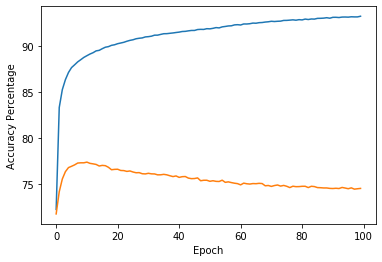

In [13]:
print("Orange is for Test and Blue is for Train")
plt.xlabel("Epoch")
plt.ylabel("Accuracy Percentage")
plt.plot(log["train_accuracy"]);
plt.plot(log["test_accuracy"]);

Orange is for Test and Blue is for Train


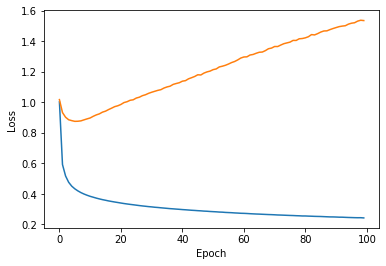

In [14]:
print("Orange is for Test and Blue is for Train")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(log["train_loss"]);
plt.plot(log["test_loss"]);

As shown above after around 15 epochs the test accuracy of the model starts to plummet but the train accuracy keeps on rising this a clear sign of overfitting doing well on training set but doing horrible on test set. Even by looking at the Loss value we can easily spot overfitting, in the training set the loss keeps lowering but in test set after around 15 epochs loss value rises rapidly. So here the best option is to train the model up until the very moment that overfitting starts, according to this 16 epochs seems like a good option. By choosing 16 epochs below, I trained and tested the model one last time.

By taking a look at plots above it's clear that increasing epochs won't be a good idea since it'll result in overfitting. Increasing number of epochs by a lot will definitely result in overfitting.

To avoid the problem we have to hit the sweet spot meaning that we know really low number of epochs will result in underfitting and really high number of epochs will result in overfitting so the best possible way is to find where the underfitting stops and overfitting starts that is the best place since it neither has underfitting nor overfitting. That is the best possible epoch to achieve. But if we want to make our model better and overcome overfitting there all a lot of way to do it and make the situation better like as we saw we can tune our hyperparameters, use different number of nodes in each hidden layer, use different number of hidden layers, study our data and know what approach to make based on the data, use other models and many more.

In [15]:
INPUT_SHAPE = 28 * 28
LEARNING_RATE = 0.0035
EPOCHS = 16
NUM_CLASSES = 20
BATCH_SIZE = 32
TRAINLOADER = generateTrainLoader(train_dataset_matrix , train_labels_matrix , NUM_CLASSES , BATCH_SIZE)
TESTLOADER = generateTestLoader(test_dataset_matrix , test_labels_matrix , NUM_CLASSES , BATCH_SIZE)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30 , input_shape = INPUT_SHAPE, activation = LeakyRelu(), weight_initializer = "uniform")
network.add_layer(NUM_CLASSES , activation = Identical(), weight_initializer = "uniform")
network.set_training_param(loss = CrossEntropy() , lr = LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 71.66166666666666	Average Loss: 1.0121412790507816
	Test: Average Accuracy: 71.2930881307747	Average Loss: 1.0353826486285564
Epoch 2:
	Train: Average Accuracy: 83.12666666666667	Average Loss: 0.600234951581487
	Test: Average Accuracy: 74.4180881307747	Average Loss: 0.9233195390511144
Epoch 3:
	Train: Average Accuracy: 85.12333333333333	Average Loss: 0.5223349541903574
	Test: Average Accuracy: 75.3931236673774	Average Loss: 0.8924173534940845
Epoch 4:
	Train: Average Accuracy: 86.14166666666667	Average Loss: 0.48368535217022485
	Test: Average Accuracy: 75.91950959488273	Average Loss: 0.8841246394022652
Epoch 5:
	Train: Average Accuracy: 86.90666666666667	Average Loss: 0.4595825594988359
	Test: Average Accuracy: 76.1860341151386	Average Loss: 0.884607490101048
Epoch 6:
	Train: Average Accuracy: 87.31333333333333	Average Loss: 0.44217168305972143
	Test: Average Accuracy: 76.42590618336887	Average Loss: 0.8845019765683989
Epoch 7:
	Train: Average Accurac